In [131]:
import numpy as np
from numpy import diff
from numpy import sum
from random import randint
import random
import math
import time

import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import trange

np.__version__

2.2.0


'1.26.4'

In [132]:
from enum import Enum

class Game_Moment(Enum):
    SECOS_1 = 1
    DADOS_1 = 2
    SECOS_2 = 3
    DADOS_2 = 4
    TABELA = 5
    FIM = 6

In [133]:
class Yan:
    def __init__(self):
        # iniciar a coluna da desordem com -1 para indicar que as celulas estão vazias
        self.desordem = {"1": -1, "2": -1, "3": -1, "4": -1, "5": -1, "6": -1, "q": -1, "f": -1, "s+": -1, "s-": -1, "x+": -1, "x-": -1, "y": -1}
        self.yangame = "YanGame"
        self.rolls_left = 2
        self.dices = [0,0,0,0,0]
        self.new_dice = list()
        self.marcado_em = ""
        self.over_minimum = False
        self.is_ended = False
        self.game_play = []
        self.next_state = self.get_game_state()
        self.reward = 0
        self.valid_moves_items = []
        

    def check_consecutive(self, l):
        n = len(l) - 1
        return sum(diff(sorted(l)) == 1) >= n


    def roll_dice(self, n):
        rolls = list()
        for i in range(n):
            rolls.append(randint(1, 6))
        rolls.sort()
        self.game_play.append("você rolou:                          " + str(rolls))
        return rolls


    def get_game_state(self):
        state = [self.rolls_left]
        for die in self.dices:
            state.append(die)
        for item in self.desordem:
            if self.desordem[item] == -1:
                state.append(1)
            else:
                state.append(0)
        return state
        

    def set_state(self, state):
        # state = ast.literal_eval(state)
        self.rolls_left = state[0]
        index = 1
        for die in range(len(self.dices)):
            self.dices[die] = state[index]
            index += 1

        index = 6
        for item in self.desordem:
            if state[index] == 1:
                self.desordem[item] = -1
            else:
                self.desordem[item] = 0
            index += 1

        return self.get_game_state()


    def get_empty_cells(self, state):
        self.set_state(state)
        avaiable_list = {}
        for item in self.desordem:
            if self.desordem[item] == -1:
                avaiable_list[item] = self.desordem[item]
        return avaiable_list
    

    def get_number_of_actions(self, state):
        return 13


    def do_the_reroll(self, n_dices):
        dices_to_reroll = '{0:05b}'.format(int(n_dices))
        self.game_play.append("dados a serem rolados novamente:     " + dices_to_reroll)
        for index in range(len(str(dices_to_reroll))):
            if dices_to_reroll[index] == "1":
                self.dices[index] = self.roll_dice(1)[0]

        self.dices.sort()
        self.game_play.append("seus dados ficaram assim:            " + str(self.dices))
        # dice_set = set(self.dices)
        # n_single = len(dice_set)
        # return (6 - n_single) * 3
        return 0


    def reset(self):
        self.game_play = []
        self.game_play.append("Jogo iniciado")
        self.desordem = {"1": -1, "2": -1, "3": -1, "4": -1, "5": -1, "6": -1, "q": -1, "f": -1, "s+": -1, "s-": -1,
                         "x+": -1, "x-": -1,
                         "y": -1}
        self.dices = self.roll_dice(5)
        self.dices.sort()
        self.is_ended = False
        self.rolls_left = 2
        self.valid_moves_items = []
        return self.get_game_state()
    

    def get_initial_state(self):
        return self.reset()
    

    def get_valid_moves(self, state):
        self.valid_moves_items = []
        valid_action = []
        index = 0
        for item in self.desordem:
            if self.desordem[item] == -1:
                self.valid_moves_items.append(item)
                valid_action.append(1)
            else:
                valid_action.append(0)
            index += 1
        return valid_action


    def is_full(self):
        return ((self.dices[0] == self.dices[2] and self.dices[3] == self.dices[4]) or (
                        self.dices[0] == self.dices[1] and self.dices[2] == self.dices[4]))


    def set_cell_value(self, cell: str):
        
        self.game_play.append("você marcou                          " + str(self.dices) + " em " + cell)
        self.game_play.append("\n")
        
        # self.marcado_em = 
        # print(self.marcado_em)
        points = 0

        if cell == "1":
            points = self.dices.count(1)
            self.desordem["1"] = points
            return points
        
        elif cell == "2":
            points = self.dices.count(2) *2
            self.desordem["2"] = points
            return points
        
        elif cell == "3":
            points = self.dices.count(3) * 3
            self.desordem["3"] = points
            return points
        
        elif cell == "4":
            points = self.dices.count(4) * 4
            self.desordem["4"] = points
            return points
        
        elif cell == "5":
            points = self.dices.count(5) * 5
            self.desordem["5"] = points
            return points
        
        elif cell == "6":
            points = self.dices.count(6) * 6
            self.desordem["6"] = points
            return points
        
        elif cell == "y":
            if self.dices[0] == self.dices[4]:
                self.desordem["y"] = sum(self.dices) + 50
                return sum(self.dices) + 50
            else:
                self.desordem["y"] = 0
                return 0
            
        elif cell == "q":
            if self.dices[0] == self.dices[3]:
                self.desordem["q"] = sum(self.dices[:4]) + 30
                return sum(self.dices[:4]) + 30
            elif self.dices[1] == self.dices[4]:
                self.desordem["q"] = sum(self.dices[1:]) + 30
                return sum(self.dices[1:]) + 30
            else:
                self.desordem["q"] = 0
                return 0
            
        elif cell == "f":
            if self.is_full():
                self.desordem["f"] = sum(self.dices) + 20
                return sum(self.dices) + 20

            else:
                self.desordem["f"] = 0
                return 0
            
        elif cell == "s+":
            if self.check_consecutive(self.dices) and self.dices[0] == 2:
                self.desordem["s+"] = 60
                return 60
            else:
                self.desordem["s+"] = 0
                return 0
            
        elif cell == "s-":
            if self.check_consecutive( self.dices) and self.dices[0] == 1:
                self.desordem["s-"] = 50
                return 50
            else:
                self.desordem["s-"] = 0
                return 0
            
        elif cell == "x+":
            if (sum(self.dices) > self.desordem["x-"]) or self.desordem["x-"] == -1:
                self.desordem["x+"] = sum(self.dices)
                return sum(self.dices)
            else:
                self.desordem["x+"] = 0
            return 0
        
        elif cell == "x-":
            if (sum(self.dices) < self.desordem["x+"]) or self.desordem["x+"] == -1:
                self.desordem["x-"] = sum(self.dices)
                return sum(self.dices)
            else:
                self.desordem["x-"] = 0
            return 0
            

    def go_for_n(self, n):
        n_count = self.dices.count(n)
        if n_count == 5 or self.rolls_left == 0:
            self.rolls_left = 2
            reward = self.set_cell_value(str(n))
            self.dices = self.roll_dice(5)
            self.dices.sort()
            return reward
        else:
            for index in range(5):
                if self.dices[index] != n:
                    self.dices[index] = self.roll_dice(1)[0]

        self.rolls_left -= 1
        self.dices.sort()
        improve = self.dices.count(n) - n_count
        return improve


    def go_for_y(self):
        dices_count = []
        for n in range (1,7):
            dices_count.append(self.dices.count(n))
        if np.max(dices_count) > 4 or self.rolls_left == 0:
            self.rolls_left = 2
            reward = self.set_cell_value("y")
            self.dices = self.roll_dice(5)
            self.dices.sort()
            return reward

        if dices_count.count(np.max(dices_count)) > 1:
            most_dices_indexs = []
            most_dices = None
            for index in range(len(dices_count)):
                if dices_count[index] == np.max(dices_count):
                    most_dices_indexs.append(index + 1)
            
            #checar qual dado manter dependendo da tabela
            for die in most_dices_indexs:
                if self.desordem[str(die)] == -1:
                    most_dices = die

            if most_dices == None:
                most_dices = most_dices_indexs[len(most_dices_indexs)-1]
        else:        
            most_dices = np.argmax(dices_count) + 1

        original_most_count_die = self.dices.count(most_dices)

        for index in range(5):
            if self.dices[index] != most_dices:
                self.dices[index] = self.roll_dice(1)[0]

        self.dices.sort()
        self.rolls_left -= 1
        final_most_count_die = self.dices.count(most_dices)
        improve = final_most_count_die - original_most_count_die
        return improve


    def go_for_q(self):
        dices_count = []
        for n in range (1,7):
            dices_count.append(self.dices.count(n))
        if np.max(dices_count) > 3 or self.rolls_left == 0:
            self.rolls_left = 2
            reward = self.set_cell_value("q")
            self.dices = self.roll_dice(5)
            self.dices.sort()
            return reward

        if dices_count.count(np.max(dices_count)) > 1:
            most_dices_indexs = []
            most_dices = None
            for index in range(len(dices_count)):
                if dices_count[index] == np.max(dices_count):
                    most_dices_indexs.append(index + 1)
            
            #checar qual dado manter dependendo da tabela
            for die in most_dices_indexs:
                if self.desordem[str(die)] == -1:
                    most_dices = die

            if most_dices == None:
                most_dices = most_dices_indexs[len(most_dices_indexs)-1]
        else:        
            most_dices = np.argmax(dices_count) + 1

        original_most_count_die = self.dices.count(most_dices)

        for index in range(5):
            if self.dices[index] != most_dices:
                self.dices[index] = self.roll_dice(1)[0]

        self.dices.sort()
        self.rolls_left -= 1
        final_most_count_die = self.dices.count(most_dices)
        improve = final_most_count_die - original_most_count_die
        return improve


    def get_dices_for_f(self):
        dices_count = []
        least_dices = None
        most_dices = None


        for n in range (1,7):
            dices_count.append(self.dices.count(n))

        if dices_count.count(np.max(dices_count)) == 2:
            for index in range(len(dices_count)):
                if dices_count[index] == 1:
                    least_dices = (index + 1)

        elif dices_count.count(np.max(dices_count)) == 1:
            most_dices = np.argmax(dices_count) +1

        elif dices_count.count(np.max(dices_count)) > 2:
            most_dices = None
            most_dices_indexs = []
            for index in range(len(dices_count)):
                if dices_count[index] == np.max(dices_count):
                    most_dices_indexs.append(index + 1)
            
            #checar qual dado manter dependendo da tabela
            for die in most_dices_indexs:
                if self.desordem[str(die)] == -1:
                    most_dices = die

            if most_dices == None:
                most_dices = most_dices_indexs[len(most_dices_indexs)-1]

        return least_dices, most_dices


    def go_for_f(self):
        
        if self.is_full() or self.rolls_left == 0:
            self.rolls_left = 2
            reward = self.set_cell_value("f")
            self.dices = self.roll_dice(5)
            self.dices.sort()
            return reward
        
        initial_least_dices, initial_most_dices = self.get_dices_for_f()

        initial_count = 0
        final_count = 0

        if initial_least_dices != None:
            initial_count = 1
            for index in range(5):
                if self.dices[index] == initial_least_dices:
                    self.dices[index] = self.roll_dice(1)[0]
            
        if initial_most_dices != None:
            initial_count = self.dices.count(initial_most_dices)
            for index in range(5):
                if self.dices[index] != initial_most_dices:
                    self.dices[index] = self.roll_dice(1)[0]
            
        final_least_dices, final_most_dices = self.get_dices_for_f()
        if initial_least_dices != None:
            if final_least_dices == None:
                final_count = 1
            else:
                final_count = 0
        else:
            if final_least_dices != None:
                final_count = 2 + (2 - initial_count)
            else:
                final_count = self.dices.count(final_most_dices) - initial_count

        self.dices.sort()
        self.rolls_left -= 1
        return final_count


    def get_reroll_dices_s(self, witch_s):
        dices_count = []
        for n in range (1,7):
            dices_count.append(self.dices.count(n))
            
        reroll_dices = []

        if witch_s == "s+":
            for n in range(dices_count[0]):
                reroll_dices.append(1)
                
            for index in range(1, 6):
                for quant in range(dices_count[index] - 1):
                    reroll_dices.append(index + 1)

        else:
            for n in range(dices_count[5]):
                reroll_dices.append(6)

            for index in range(5):
                for quant in range(dices_count[index] - 1):
                    reroll_dices.append(index + 1)
       
        reroll_dices.sort()

        return reroll_dices


    def go_for_s(self, witch_s):
        
        if self.rolls_left == 0:
            self.rolls_left = 2
            reward = self.set_cell_value(witch_s)
            self.dices = self.roll_dice(5)
            self.dices.sort()
            return reward
        
        if self.check_consecutive(self.dices) and self.dices[0] == 2 and witch_s == "s+":
            self.rolls_left = 2
            reward = self.set_cell_value("s+")
            self.dices = self.roll_dice(5)
            self.dices.sort()
            return reward
        
        if self.check_consecutive(self.dices) and self.dices[0] == 1 and witch_s == "s-":
            self.rolls_left = 2
            reward = self.set_cell_value("s-")
            self.dices = self.roll_dice(5)
            self.dices.sort()
            return reward
        
        reroll_dices = self.get_reroll_dices_s(witch_s)
        original_n_dice_roled = len(reroll_dices)

        for index in range(5):
            if self.dices[index] in reroll_dices:
                reroll_dices = np.delete(reroll_dices, 0)
                self.dices[index] = self.roll_dice(1)[0]

        self.rolls_left -= 1
        self.dices.sort()
        final_n_dice_roled = len(self.get_reroll_dices_s(witch_s))
        improve = original_n_dice_roled - final_n_dice_roled
        return improve
    

    def get_next_state(self, state, action):
        self.set_state(state)
        action = int(action)
        self.reward = 0

        if action < 6:
            self.reward = self.go_for_n(action+1)
        elif action == 6:
            self.reward = self.go_for_q()
        elif action == 7:
            self.reward = self.go_for_f()
        elif action == 8:
            self.reward = self.go_for_s("s+")
        elif action == 9:
            self.reward = self.go_for_s("s-")
        elif action == 10:
            self.rolls_left = 2
            self.set_cell_value("x+")
            self.reward = 0
            self.dices = self.roll_dice(5)
            self.dices.sort()
        elif action == 11:
            self.rolls_left = 2
            self.set_cell_value("x-")
            self.reward = 0
            self.dices = self.roll_dice(5)
            self.dices.sort()
        elif action == 12:
            self.reward = self.go_for_y()
        else:
            print(action)
            breakpoint()
        a=1
        return (self.get_game_state(), self.reward, self.check_ended(self.get_game_state()))


    def check_ended(self, state):
        self.set_state(state)
        return -1 not in self.desordem.values()
    

    def get_value_and_terminated(self, state, action):
        if action == None:
            return (0, False)
        self.set_state(state)
        if self.check_ended(state):
            return self.get_total_score(state), self.check_ended(state)
        else:
            return self.reward, self.check_ended(state)
    

    def get_total_score(self, state):
        self.set_state(state)
        self.score_values = list(self.desordem.values())
        self.total = sum(self.score_values)
        total_upper = sum(self.score_values[0:6])
        if total_upper >= 60:
            self.total += 30
        # print()
        self.game_play.append("sua tabela ficou assim:              " + str(self.desordem))
        self.game_play.append("TOTAL:                               " + str(self.total))
        # print("total: ", self.total)
        # print("sua tabela ficou assim: ", self.desordem)
        # print()
        

        return self.total
    

    def get_encoded_state(self, state):
        rerolls_left = int(state[0])/2
        dice = int(''.join(map(str,state[1:6])))
        dice = dice / 66666
        decimal_table = int(''.join(map(str,state[6:])), 2)
        decimal_table = decimal_table/8191
        return (rerolls_left, dice, decimal_table)


In [134]:
# class Yan:
#     def __init__(self):
#         # iniciar a coluna da desordem com -1 para indicar que as celulas estão vazias
#         self.desordem = {"1": -1, "2": -1, "3": -1, "4": -1, "5": -1, "6": -1, "q": -1, "f": -1, "s+": -1, "s-": -1, "x+": -1, "x-": -1, "y": -1}
#         self.yangame = "YanGame"
#         self.rolls_left = 2
#         self.dices = [0,0,0,0,0]
#         self.new_dice = list()
#         self.marcado_em = ""
#         self.over_minimum = False
#         self.is_ended = False
#         self.game_play = []
#         self.next_state = self.get_game_state()
#         self.reward = 0
        

#         # self.action_size = self.row_count * self.column_count
    
#     def check_consecutive(self, l):
#         n = len(l) - 1
#         return sum(diff(sorted(l)) == 1) >= n


#     def roll_dice(self, n):
#         rolls = list()
#         for i in range(n):
#             rolls.append(randint(1, 6))
#         rolls.sort()
#         self.game_play.append("você rolou:                          " + str(rolls))
#         return rolls


#     def get_game_state(self):
#         state = [self.rolls_left]
#         for die in self.dices:
#             state.append(die)
#         for item in self.desordem:
#             state.append(self.desordem[item])
#         return state
        
#     def set_state(self, state):
#         self.rolls_left = state[0]
#         index = 1
#         for die in range(len(self.dices)):
#             self.dices[die] = state[index]
#             index += 1

#         index = 6
#         for item in self.desordem:
#             self.desordem[item] = state[index]
#             index += 1

#         return self.get_game_state()


#     # onde é possivel anotar o resultado dos dados
#     def get_empty_cells(self, state):
#         self.set_state(state)
#         avaiable_list = {}
#         for item in self.desordem:
#             if self.desordem[item] == -1:
#                 avaiable_list[item] = self.desordem[item]
#         return avaiable_list
    

#     def get_number_of_actions(self, state):
#         return 13
#         if state[0] == Game_Moment.TABELA:
#             # se estivermos na tabela, retornamos quantidade de celulas em branco
#             return len(self.get_empty_cells(state))
#         elif state[0] == Game_Moment.SECOS_1 or state[0] == Game_Moment.SECOS_2:
#             #se tivermos no SECO retornamos binário "marcar/ não marcar"
#             return 2
#         else:
#             # se estivermos nos dados retornamos 31 combinações de dados
#             return 31


#     def do_the_reroll(self, n_dices):
#         dices_to_reroll = '{0:05b}'.format(int(n_dices))
#         self.game_play.append("dados a serem rolados novamente:     " + dices_to_reroll)
#         for index in range(len(str(dices_to_reroll))):
#             if dices_to_reroll[index] == "1":
#                 self.dices[index] = self.roll_dice(1)[0]

#         self.dices.sort()
#         self.game_play.append("seus dados ficaram assim:            " + str(self.dices))
#         dice_set = set(self.dices)
#         n_single = len(dice_set)
#         # return (6 - n_single) * 3
#         return 0


#     def reset(self):
#         self.game_play = []
#         self.game_play.append("Jogo iniciado")
#         self.desordem = {"1": -1, "2": -1, "3": -1, "4": -1, "5": -1, "6": -1, "q": -1, "f": -1, "s+": -1, "s-": -1,
#                          "x+": -1, "x-": -1,
#                          "y": -1}
#         self.dices = self.roll_dice(5)
#         self.dices.sort()
#         self.is_ended = False
#         self.rolls_left = 2

#         return self.get_game_state()
    

#     def get_initial_state(self):
#         return self.reset()
    

#     def get_valid_moves(self, state):
#         valid_action = []
#         for item in self.desordem:
#             if self.desordem[item] == -1:
#                 valid_action.append(1)
#             else:
#                 valid_action.append(0)
#         return valid_action
#         game_state = state[0]       
#         if game_state == Game_Moment.TABELA:
#             # se estivermos na tabela, retornamos quantidade de celulas em branco
#             return np.ones(len(self.get_empty_cells(state)))
#         elif game_state == Game_Moment.SECOS_1 or game_state == Game_Moment.SECOS_2:
#             #se tivermos no SECO retornamos binário "marcar/ não marcar"
#             return np.ones(2)
#         else:
#             # se estivermos nos dados retornamos 31 combinações de dados
#             return np.ones(31)
#         # return self.get_number_of_actions()
#         # return (state.reshape(-1) == 0).astype(np.uint8)


#     def is_full(self):
#         return ((self.dices[0] == self.dices[2] and self.dices[3] == self.dices[4]) or (
#                         self.dices[0] == self.dices[1] and self.dices[2] == self.dices[4]))


#     def set_cell_value(self, cell: str):
        
#         self.game_play.append("você marcou                          " + str(self.dices) + " em " + cell)
#         self.game_play.append("\n")
        
#         # self.marcado_em = 
#         # print(self.marcado_em)
#         points = 0

#         if cell == "1":
#             points = self.dices.count(1)
#             self.desordem["1"] = points
#             return points
        
#         elif cell == "2":
#             points = self.dices.count(2) *2
#             self.desordem["2"] = points
#             return points
        
#         elif cell == "3":
#             points = self.dices.count(3) * 3
#             self.desordem["3"] = points
#             return points
        
#         elif cell == "4":
#             points = self.dices.count(4) * 4
#             self.desordem["4"] = points
#             return points
        
#         elif cell == "5":
#             points = self.dices.count(5) * 5
#             self.desordem["5"] = points
#             return points
        
#         elif cell == "6":
#             points = self.dices.count(6) * 6
#             self.desordem["6"] = points
#             return points
        
#         elif cell == "y":
#             if self.dices[0] == self.dices[4]:
#                 self.desordem["y"] = sum(self.dices) + 50
#                 return sum(self.dices) + 50
#             else:
#                 self.desordem["y"] = 0
#                 return 0
            
#         elif cell == "q":
#             if self.dices[0] == self.dices[3]:
#                 self.desordem["q"] = sum(self.dices[:4]) + 30
#                 return sum(self.dices[:4]) + 30
#             elif self.dices[1] == self.dices[4]:
#                 self.desordem["q"] = sum(self.dices[1:]) + 30
#                 return sum(self.dices[1:]) + 30
#             else:
#                 self.desordem["q"] = 0
#                 return 0
            
#         elif cell == "f":
#             if self.is_full():
#                 self.desordem["f"] = sum(self.dices) + 20
#                 return sum(self.dices) + 20

#             else:
#                 self.desordem["f"] = 0
#                 return 0
            
#         elif cell == "s+":
#             if self.check_consecutive(self.dices) and self.dices[0] == 2:
#                 self.desordem["s+"] = 60
#                 return 60
#             else:
#                 self.desordem["s+"] = 0
#                 return 0
            
#         elif cell == "s-":
#             if self.check_consecutive( self.dices) and self.dices[0] == 1:
#                 self.desordem["s-"] = 50
#                 return 50
#             else:
#                 self.desordem["s-"] = 0
#                 return 0
            
#         elif cell == "x+":
#             if (sum(self.dices) > self.desordem["x-"]) or self.desordem["x-"] == -1:
#                 self.desordem["x+"] = sum(self.dices)
#                 return sum(self.dices)
#             else:
#                 self.desordem["x+"] = 0
#             return 0
        
#         elif cell == "x-":
#             if (sum(self.dices) < self.desordem["x+"]) or self.desordem["x+"] == -1:
#                 self.desordem["x-"] = sum(self.dices)
#                 return sum(self.dices)
#             else:
#                 self.desordem["x-"] = 0
#             return 0
            

#     def go_for_n(self, n):
#         n_count = self.dices.count(n)
#         if n_count == 5 or self.rolls_left == 0:
#             self.rolls_left = 2
#             reward = self.set_cell_value(str(n))
#             self.dices = self.roll_dice(5)
#             self.dices.sort()
#             return reward
#         else:
#             for index in range(5):
#                 if self.dices[index] != n:
#                     self.dices[index] = self.roll_dice(1)[0]

#         self.rolls_left -= 1
#         self.dices.sort()
#         return 0


#     def go_for_y(self):
#         dices_count = []
#         for n in range (1,7):
#             dices_count.append(self.dices.count(n))
#         if np.max(dices_count) > 4 or self.rolls_left == 0:
#             self.rolls_left = 2
#             reward = self.set_cell_value("y")
#             self.dices = self.roll_dice(5)
#             self.dices.sort()
#             return reward

#         if dices_count.count(np.max(dices_count)) > 1:
#             most_dices_indexs = []
#             most_dices = None
#             for index in range(len(dices_count)):
#                 if dices_count[index] == np.max(dices_count):
#                     most_dices_indexs.append(index + 1)
            
#             #checar qual dado manter dependendo da tabela
#             for die in most_dices_indexs:
#                 if self.desordem[str(die)] == -1:
#                     most_dices = die

#             if most_dices == None:
#                 most_dices = most_dices_indexs[len(most_dices_indexs)-1]
#         else:        
#             most_dices = np.argmax(dices_count) + 1

#         a=1

#         for index in range(5):
#             if self.dices[index] != most_dices:
#                 self.dices[index] = self.roll_dice(1)[0]

#         self.dices.sort()
#         self.rolls_left -= 1
#         return 0


#     def go_for_q(self):
#         dices_count = []
#         for n in range (1,7):
#             dices_count.append(self.dices.count(n))
#         if np.max(dices_count) > 3 or self.rolls_left == 0:
#             self.rolls_left = 2
#             reward = self.set_cell_value("q")
#             self.dices = self.roll_dice(5)
#             self.dices.sort()
#             return reward

#         if dices_count.count(np.max(dices_count)) > 1:
#             most_dices_indexs = []
#             most_dices = None
#             for index in range(len(dices_count)):
#                 if dices_count[index] == np.max(dices_count):
#                     most_dices_indexs.append(index + 1)
            
#             #checar qual dado manter dependendo da tabela
#             for die in most_dices_indexs:
#                 if self.desordem[str(die)] == -1:
#                     most_dices = die

#             if most_dices == None:
#                 most_dices = most_dices_indexs[len(most_dices_indexs)-1]
#         else:        
#             most_dices = np.argmax(dices_count) + 1

#         for index in range(5):
#             if self.dices[index] != most_dices:
#                 self.dices[index] = self.roll_dice(1)[0]

#         self.dices.sort()
#         self.rolls_left -= 1
#         return 0


#     def go_for_f(self):
#         dices_count = []
#         for n in range (1,7):
#             dices_count.append(self.dices.count(n))
#         if self.is_full() or self.rolls_left == 0:
#             self.rolls_left = 2
#             reward = self.set_cell_value("f")
#             self.dices = self.roll_dice(5)
#             self.dices.sort()
#             return reward

#         if dices_count.count(np.max(dices_count)) == 2:
#             least_dices = None
#             for index in range(len(dices_count)):
#                 if dices_count[index] == 1:
#                     least_dices = (index + 1)
#             for index in range(5):
#                 if self.dices[index] == least_dices:
#                     self.dices[index] = self.roll_dice(1)[0]

#         elif dices_count.count(np.max(dices_count)) == 1:
#             most_dices = np.argmax(dices_count) +1
#             for index in range(5):
#                 if self.dices[index] != most_dices:
#                     self.dices[index] = self.roll_dice(1)[0]

#         elif dices_count.count(np.max(dices_count)) > 2:
#             most_dices = None
#             most_dices_indexs = []
#             for index in range(len(dices_count)):
#                 if dices_count[index] == np.max(dices_count):
#                     most_dices_indexs.append(index + 1)
            
#             #checar qual dado manter dependendo da tabela
#             for die in most_dices_indexs:
#                 if self.desordem[str(die)] == -1:
#                     most_dices = die

#             if most_dices == None:
#                 most_dices = most_dices_indexs[len(most_dices_indexs)-1]

#             for index in range(5):
#                 if self.dices[index] != most_dices:
#                     self.dices[index] = self.roll_dice(1)[0]

#         self.dices.sort()
#         self.rolls_left -= 1
#         return 0


#     def go_for_s(self, witch_s):
#         dices_count = []
#         for n in range (1,7):
#             dices_count.append(self.dices.count(n))
#         if self.rolls_left == 0:
#             self.rolls_left = 2
#             reward = self.set_cell_value(witch_s)
#             self.dices = self.roll_dice(5)
#             self.dices.sort()
#             return reward
        
#         if self.check_consecutive(self.dices) and self.dices[0] == 2 and witch_s == "s+":
#             self.rolls_left = 2
#             reward = self.set_cell_value("s+")
#             self.dices = self.roll_dice(5)
#             self.dices.sort()
#             return reward
        
#         if self.check_consecutive(self.dices) and self.dices[0] == 1 and witch_s == "s-":
#             self.rolls_left = 2
#             reward = self.set_cell_value("s-")
#             self.dices = self.roll_dice(5)
#             self.dices.sort()
#             return reward
        
#         reroll_dices = []

#         if witch_s == "s+":
#             for n in range(dices_count[0]):
#                 reroll_dices.append(1)
                
#             for index in range(1, 6):
#                 for quant in range(dices_count[index] - 1):
#                     reroll_dices.append(index + 1)

#         else:
#             for n in range(dices_count[5]):
#                 reroll_dices.append(6)

#             for index in range(5):
#                 for quant in range(dices_count[index] - 1):
#                     reroll_dices.append(index + 1)

#         reroll_dices.sort()

#         for index in range(5):
#             if self.dices[index] in reroll_dices:
#                 reroll_dices = np.delete(reroll_dices, 0)
#                 self.dices[index] = self.roll_dice(1)[0]

#         self.rolls_left -= 1
#         self.dices.sort()
#         return 0


#     def get_next_state(self, state, action):
#         self.set_state(state)
#         action = int(action)
#         # print(action)

#         if action < 6:
#             self.reward = self.go_for_n(action+1)
#         elif action == 6:
#             self.reward = self.go_for_q()
#         elif action == 7:
#             self.reward = self.go_for_f()
#         elif action == 8:
#             self.reward = self.go_for_s("s+")
#         elif action == 9:
#             self.reward = self.go_for_s("s-")
#         elif action == 10:
#             self.rolls_left = 2
#             self.reward = self.set_cell_value("x+")
#             self.dices = self.roll_dice(5)
#             self.dices.sort()
#         elif action == 11:
#             self.rolls_left = 2
#             self.reward = self.set_cell_value("x-")
#             self.dices = self.roll_dice(5)
#             self.dices.sort()
#         elif action == 12:
#             self.reward = self.go_for_y()
#         else:
#             breakpoint()
        
#         return (self.get_game_state())


#     def check_ended(self, state):
#         self.set_state(state)
#         return -1 not in self.desordem.values()
    

#     def get_value_and_terminated(self, state, action):
#         if action == None:
#             return (0, False)
#         self.set_state(state)
#         if self.check_ended(state):
#             return self.get_total_score(state), self.check_ended(state)
#         else:
#             return self.reward, self.check_ended(state)
    

#     def get_total_score(self, state):
#         self.set_state(state)
#         self.score_values = list(self.desordem.values())
#         self.total = sum(self.score_values)
#         total_upper = sum(self.score_values[0:6])
#         if total_upper >= 60:
#             self.total += 30
#         # print()
#         self.game_play.append("sua tabela ficou assim:              " + str(self.desordem))
#         self.game_play.append("TOTAL:                               " + str(self.total))
#         # print("total: ", self.total)
#         # print("sua tabela ficou assim: ", self.desordem)
#         # print()
        

#         return self.total
    

#     def get_encoded_state(self, state):
#         encoded = state.copy()
#         encoded[0] = state[0]
#         encoded = np.stack(encoded).astype(np.float32)
#         return encoded



In [135]:
# game = Yan()
# state = game.get_initial_state()
# def play_game():
#     while True:
#         print(f"rerolls: {game.rolls_left} | Dados: {state[1:6]} | Tabela: {game.desordem}")
#         time.sleep(1)
        
#         user_input = input()
#         action = None
#         if user_input == "1":
#             action = 0
#         if user_input == "2":
#             action = 1
#         if user_input == "3":
#             action = 2
#         if user_input == "4":
#             action = 3
#         if user_input == "5":
#             action = 4
#         if user_input == "6":
#             action = 5
#         if user_input == "q":
#             action = 6
#         if user_input == "f":
#             action = 7
#         if user_input == "s+":
#             action = 8
#         if user_input == "s-":
#             action = 9
#         if user_input == "x+":
#             action = 10
#         if user_input == "x-":
#             action = 11
#         if user_input == "y":
#             action = 12
#         state = game.get_next_state(state, action)
#         if game.check_ended(state):
#             print(f"Total: {game.get_total_score(state)}")
#             print()
#             print()
#             print()

#             game.reset()
#             state = game.get_initial_state()

#         else:
#             print(f"Reward: {game.reward}")
#             print()


In [136]:
NUM_CLASSES = 13
NUM_FEATURES = 3
RANDOM_SEED = 42


In [137]:

device  = "cuda" if torch.cuda.is_available() else "cpu"


class BobNet(nn.Module):
    def __init__(self, input_features=NUM_FEATURES, output_features=NUM_CLASSES, hiden_units = 32, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        input_layer = nn.Linear(in_features=input_features, out_features=hiden_units)
        hiden_layers = nn.Linear(in_features=hiden_units, out_features=hiden_units)
        classification_layer = nn.Linear(in_features=512, out_features=47)
        output_layer = nn.Linear(in_features=47, out_features=1)
        relu = nn.ReLU()


        self.policyHead = nn.Sequential(
            input_layer,
            relu,
            nn.Linear(in_features=hiden_units, out_features=512),
            relu,
            nn.Linear(in_features=512, out_features=1024),
            relu,
            # nn.Linear(in_features=1024, out_features=2048),
            # relu,
            nn.Linear(in_features=1024, out_features=2048),
            relu,
            nn.Linear(in_features=2048, out_features=1024),
            relu,
            nn.Linear(in_features=1024, out_features=13)
        )
        self.valueHead = nn.Sequential(
            input_layer,
            relu,
            nn.Linear(in_features=hiden_units, out_features=512),
            relu,
            nn.Linear(in_features=512, out_features=1024),
            relu,
            # nn.Linear(in_features=1024, out_features=2048),
            # relu,
            nn.Linear(in_features=1024, out_features=2048),
            relu,
            nn.Linear(in_features=2048, out_features=1024),
            relu,
            nn.Linear(in_features=1024, out_features=512),
            relu,
            classification_layer,
            relu,
            output_layer
        )

        

    def forward(self, x):
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value
        
# policy_model = BobNet().to(device)
# policy_model


In [138]:
class Node:
    def __init__(self, game:Yan, args, state, parent=None, action_taken=None, prior=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior
        
        self.children = []
        
        self.visit_count = 0
        self.value_sum = 0
        
    def is_fully_expanded(self):
        return len(self.children) > 0
    
    def select(self):
        best_child = None
        best_ucb = -np.inf
        
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb
                
        return best_child
    
    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior
    
    def expand(self, policy):
        for action, prob in enumerate(policy):
            if prob > 0:
                child_state = self.state.copy()
                child_state, child_reward, child_terminated = self.game.get_next_state(child_state, action)

                child = Node(self.game, self.args, child_state, self, action, prob)
                self.children.append(child)
                
        return child
    
            
    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1
        
        value = self.game.reward
        if self.parent is not None:
            self.parent.backpropagate(value)  


class MCTS:
    def __init__(self, game:Yan, args, model):
        self.game = game
        self.args = args
        self.model = model

    @torch.no_grad() 
    def search(self, state):
        root = Node(self.game, self.args, state)
        
        for search in range(self.args['num_searches']):
            node = root
            
            while node.is_fully_expanded():
                node = node.select()
                
            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
            
            if not is_terminal:
                tensor = torch.tensor(self.game.get_encoded_state(node.state)).unsqueeze(0)
                policy, value = self.model(
                    tensor.float()
                )   
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                valid_moves = self.game.get_valid_moves(node.state)
                policy *= valid_moves
                policy /= np.sum(policy)
                
                value = value.item()
                
                node.expand(policy)
                
            node.backpropagate(value)    
            
            
        action_probs = self.game.get_valid_moves(state)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs
        
        
        

In [139]:
class AlphaZero:
    def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTS(game, args, model)
        
    def selfPlay(self):
        memory = []
        # player = 1
        state = self.game.get_initial_state()
        
        while True:
            # neutral_state = self.game.change_perspective(state, player)
            action_probs = self.mcts.search(state)
            
            memory.append((state, action_probs))
            
            action = np.random.choice(self.game.get_number_of_actions(state), p=action_probs)
            
            state, reward, terminal = self.game.get_next_state(state, action)
            
            value, is_terminal = self.game.get_value_and_terminated(state, action)
            
            if is_terminal:
                returnMemory = []
                for hist_state, hist_action_probs in memory:
                    hist_outcome = value
                    returnMemory.append((
                        self.game.get_encoded_state(hist_state),
                        hist_action_probs,
                        hist_outcome
                    ))
                return returnMemory
            
            # player = self.game.get_opponent(player)
                
    def train(self, memory):
        random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory) - 1, batchIdx + self.args['batch_size'])] # Change to memory[batchIdx:batchIdx+self.args['batch_size']] in case of an error
            state, policy_targets, value_targets = zip(*sample)
            
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)
            
            state = torch.tensor(state, dtype=torch.float32)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32)
            value_targets = torch.tensor(value_targets, dtype=torch.float32)
            
            out_policy, out_value = self.model(state)
            
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss
            
            self.optimizer.zero_grad() # change to self.optimizer
            loss.backward()
            self.optimizer.step() # change to self.optimizer
    
    def learn(self):
        for iteration in range(self.args['num_iterations']):
            memory = []
            
            self.model.eval()
            for selfPlay_iteration in trange(self.args['num_selfPlay_iterations']):
                memory += self.selfPlay()
                
            self.model.train()
            for epoch in trange(self.args['num_epochs']):
                self.train(memory)
            
            torch.save(self.model.state_dict(), f"model_{iteration}.pt")
            torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}.pt")

In [140]:
game = Yan()

model = BobNet()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

args = {
    'C': 2,
    'num_searches': 60,
    'num_iterations': 3,
    'num_selfPlay_iterations': 100,
    'num_epochs': 10,
    'batch_size': 64
}

alphaZero = AlphaZero(model, optimizer, game, args)
alphaZero.learn()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [141]:
game = Yan()

args = {
    'C': 2,
    'num_searches': 1000
}
model = BobNet()
model.eval()
mcts = MCTS(game, args, model)

state = game.get_initial_state()

def play_game():
    while True:
        # print(state)
        
        mcts_probs = mcts.search(state)
        action = np.argmax(mcts_probs)
            
        state = game.get_next_state(state, action)
        
        value, is_terminal = game.get_value_and_terminated(state, action)
        
        if is_terminal:
            # print(game.desordem)
            # print(game.get_total_score(state))
            game.reset()
            break
            
        # player = game.get_opponent(player)


[2, 1, 1, 2, 3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-4.950910806655884e-06 [0.10697905 0.1077187  0.09861556 0.12817146 0.07839997 0.07115675
 0.07391981 0.07309419 0.06469342 0.06172723 0.01970326 0.03393845
 0.08188215]


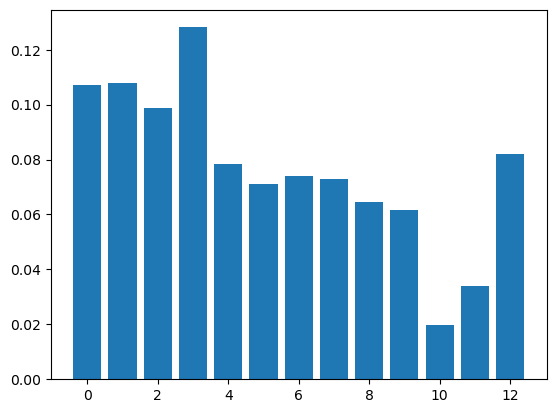

In [165]:
import matplotlib.pyplot as plt

yan = Yan()

state = yan.get_initial_state()
# state = yan.get_next_state(state, 2, 1)
# state = yan.get_next_state(state, 7, -1)

# print(state)

encoded_state = yan.get_encoded_state(state)

print(state)

tensor_state = torch.tensor(encoded_state).unsqueeze(0)
model = BobNet().to(device)

model.load_state_dict(torch.load('model_2.pt', map_location=device))
model.eval()

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()

print(value, policy)

plt.bar(range(NUM_CLASSES), policy)
plt.show()
